In [1]:
import json
import re
import time
import logging
import threading
import functools
import collections
import numpy as np
from nltk.corpus import words
import spacy.tokenizer, spacy.lemmatizer
import urllib.parse
import nltk
import gensim
import gensim.corpora as corpora
from wordcloud import WordCloud

# logging.basicConfig(format='\r%(asctime)s : %(levelname)s : %(message)s', level=logging.NOTSET)


In [2]:
nltk.download('words')
common_words = set(words.words())

[nltk_data] Downloading package words to
[nltk_data]     /Users/mafuangimemkamon/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [317]:
"""
with open("pages.json", "r") as f:
    pages = json.load(f)

with open("name-visit-count-all.json", "r") as f:
    counts = json.load(f)

f = lambda k: "https://en.wikipedia.org"+urllib.parse.unquote(k)
l = sorted([(v, f(k)) for k,v in counts.items() if v], reverse=True)[:500]
for c, k in l:
    print(c, k)
"""

FileNotFoundError: [Errno 2] No such file or directory: 'pages.json'

In [ ]:
nlp = spacy.load('en_core_web_sm')

In [ ]:
def clean(text):
    sections = re.split("===* .* ===*", text)
    return [token.lemma_ 
                for token in nlp(sections[0]) 
                if token.is_alpha 
                and not token.is_stop 
                and token.lemma_ not in {'-PRON-', "the", "a", "an"}]

In [ ]:
"""
cleaned = {}
counter = 0
for link, (text, cat) in pages.items():
    cleaned[link] = clean(text)
    counter += 1
    counter % 10 or print("\r", counter, link, end="  "*20)
"""

In [3]:
with open("lemmatized-tokenized.json", "r") as f:
    cleaned = json.load(f)

links, documents = zip(*sorted(cleaned.items()))
counts = collections.Counter([w for d in documents for w in d])
documents = [[w for w in d if counts[w] > 20] for d in documents]

In [4]:
id2word = corpora.Dictionary(documents)
corpus = [id2word.doc2bow(text) for text in documents]


In [5]:
from gensim import models
def custom_df2idf(docfreq, totaldocs, log_base=2.0, add=0.0):
    return add + np.log(float(totaldocs) / docfreq)/ np.log(log_base)
    #add + np.log(float(totaldocs) / docfreq) / np.log(log_base)
def idf_smooth(docfreq, totaldocs):
    return np.log(float(totaldocs)/(docfreq+1))
def idf_prob(docfreq, totaldocs):
    return np.log((float(totaldocs)-docfreq)/(docfreq))

tf = models.TfidfModel(corpus, id2word=id2word, smartirs = 'nnn')
sigs = [(id2word[i], sig) for i, sig in tf.idfs.items() if id2word[i] in common_words]
sigs.sort(key = lambda i:-i[1])
sigs[0:20]

[('bear', 8303),
 ('know', 4783),
 ('in', 4345),
 ('film', 3708),
 ('role', 3254),
 ('include', 3234),
 ('win', 2948),
 ('year', 2923),
 ('award', 2903),
 ('play', 2898),
 ('series', 2876),
 ('television', 2827),
 ('actor', 2720),
 ('star', 2584),
 ('career', 2568),
 ('time', 2550),
 ('best', 2444),
 ('actress', 2280),
 ('work', 2269),
 ('lead', 2193)]

## Generate bad word cloud

In [6]:
tfidf = models.TfidfModel(corpus, id2word=id2word, wglobal = idf_smooth)
sigs = [(id2word[i], sig, tfidf.idfs.get(i), sig* tfidf.idfs.get(i) ) for i, sig in tf.idfs.items() if id2word[i] in common_words]
sigs.sort(key = lambda i:-i[3])
weight = dict([(item[0], item[1]) for item in sigs])
wordcloud = WordCloud(background_color="white",
    max_words=200,
    width = 1024,
    height = 720)
wordcloud.generate_from_frequencies(weight)
# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt

plt.imshow(wordcloud, interpolation='bilinear')
plt.savefig('wordcloud_alternate1.png')
plt.axis("off")

(-0.5, 1023.5, 719.5, -0.5)

In [7]:
tfidf = models.TfidfModel(corpus, id2word=id2word, wglobal = idf_prob)
mysig = [(id2word[i], sig, tfidf.idfs.get(i), sig* tfidf.idfs.get(i) ) for i, sig in tf.idfs.items() if id2word[i] in common_words]
mysig.sort(key = lambda i:-i[3])
mysig[0:20]


[('lead', 2193, 1.2697502977024029, 2784.5624028613697),
 ('work', 2269, 1.225899014540633, 2781.5648639926962),
 ('actress', 2280, 1.2196389210703353, 2780.7767400403645),
 ('world', 2069, 1.3437137323377766, 2780.1437122068596),
 ('best', 2444, 1.1287059083299142, 2758.55723995831),
 ('good', 1852, 1.4815063621405717, 2743.7497826843387),
 ('debut', 1849, 1.4834956667073327, 2742.983487741858),
 ('time', 2550, 1.0721206732211332, 2733.90771671389),
 ('appear', 1801, 1.5156701294202217, 2729.721903085819),
 ('career', 2568, 1.0626676156838226, 2728.9304370760565),
 ('star', 2584, 1.0543012423431986, 2724.314410214825),
 ('receive', 1780, 1.5299568447640948, 2723.3231836800887),
 ('later', 1775, 1.5333778737240564, 2721.7457258602003),
 ('after', 1759, 1.5443762300258252, 2716.5577886154265),
 ('new', 1757, 1.5457565461261302, 2715.8942515436106),
 ('national', 1739, 1.558235410208222, 2709.771378352098),
 ('begin', 1701, 1.5849187122025863, 2695.9467294565993),
 ('singer', 1658, 1.615

(-0.5, 1023.5, 719.5, -0.5)

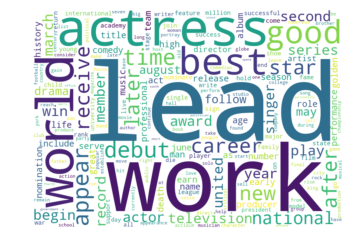

In [8]:
weight = dict([(item[0], item[3]) for item in mysig])
wordcloud = WordCloud(background_color="white",
    max_words=200,
    width = 1024,
    height = 720)
wordcloud.generate_from_frequencies(weight)
# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt

plt.imshow(wordcloud, interpolation='bilinear')
plt.savefig('wordcloud.png')
plt.axis("off")



In [9]:
counts = [i for _, i in sigs]
counts.sort(reverse=True)
import random
import matplotlib.pyplot as plt
plt.hist(counts, bins=2500, density=True)
plt.axis([0, 400, 0, None])
plt.title('Word Count Distribution, 93.1% shown')
plt.savefig('Word Count Distribution.png')
print(1 - sum(1 for i in counts if i > 400) / len(counts))
plt.show()

ValueError: too many values to unpack (expected 2)

In [10]:
counts = [i for _, i in sigs]
counts.sort(reverse=True)

import matplotlib.pyplot as plt
plt.hist(counts, 
         bins=np.logspace(np.log(1), np.log(1000.0), 200))
plt.axis([1, 3000, 1, None])
plt.xscale("log")
plt.show()


ValueError: too many values to unpack (expected 2)

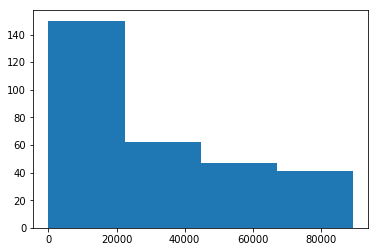

In [11]:
import numpy as np
plt.hist(np.arange(300)**2, bins=4)
plt.show()

In [12]:
lda_model2 = models.ldamodel.LdaModel(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=100,
                                       update_every=1,
                                       chunksize=100,
                                       passes=200,
                                       alpha='auto',
                                       per_word_topics=True)


In [13]:
for j in range(10):
    words = [id2word[i] for i, _ in lda_model2.get_topic_terms(j)]
    print(j, " ".join(words))
    print("-"*30)
lda_model2.save('10Topics200Passes')

0 team win world club play league player cup year season
------------------------------
1 world south win title open one cricket grand single horror
------------------------------
2 film award role actress actor star drama series play good
------------------------------
3 work in year new life early include later age book
------------------------------
4 world time champion title championship win professional wwe in wrestling
------------------------------
5 player season football play nba national time win team league
------------------------------
6 american bear know television series co best actor show host
------------------------------
7 album release music singer single indian debut number record in
------------------------------
8 british english know king bear william john child young write
------------------------------
9 serve president united war states party in state political government
------------------------------


In [14]:
print(lda_model2.get_document_topics.__doc__)


        Args:
            bow (list): Bag-of-words representation of the document to get topics for.
            minimum_probability (float): Ignore topics with probability below this value
                (None by default). If set to None, a value of 1e-8 is used to prevent 0s.
            per_word_topics (bool): If True, also returns a list of topics, sorted in
                descending order of most likely topics for that word. It also returns a list
                of word_ids and each words corresponding topics' phi_values, multiplied by
                feature length (i.e, word count).
            minimum_phi_value (float): if `per_word_topics` is True, this represents a lower
                bound on the term probabilities that are included (None by default). If set
                to None, a value of 1e-8 is used to prevent 0s.

        Returns:
            topic distribution for the given document `bow`, as a list of
            `(topic_id, topic_probability)` 2-tuples.
    

In [15]:
lda_model2.id2word[5]

'best'

In [16]:
#model = lda_model2.load("lda.model")

In [17]:
for i in model.show_topics(12):
    print(*i)
    print("--"*20)

NameError: name 'model' is not defined